Melakukan import libraries yang dibutukan

In [2]:
import pandas as pd
import tensorflow as tf
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import codecs
import numpy as np
factory=StemmerFactory()
stemmer=factory.create_stemmer()

Melakukan reading data hate speech tweet

In [ ]:
stopword=pd.read_csv('data/stopwordbahasa.csv',header=None)
stopword=stopword.rename(columns={0:'stopwords'})
kamus_alay=pd.read_csv('data/new_kamusalay.csv',header=None,encoding='latin-1')
kamus_alay=kamus_alay.rename(columns={0:'asli',1:'baru'})

Preprocessing Text

In [9]:
#Stemming text
def stemWord(x):
    return stemmer.stem(x)

In [10]:
#Lower text
def lowercase(text):
    return text.lower()

In [11]:
#Remove unnecessary charracters
def removeUnnecessary(text):
    text=re.sub('\n','',text) # menghapus newline
    text=re.sub('rt','',text) # menghapus kata retweet
    text=re.sub('user','',text) # menghapus kata user
    text=re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # menghapus url
    text = re.sub('  +', ' ', text) # menghapus karakter ekstra
    text=re.sub('x.{3} | x.{2}','',text) # menghapus pola emoji 
    return text

In [12]:
#Remove non alphanumeric character
def removeNonAlphanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    text="".join(filter(lambda x: not x.isdigit(), text))
    return text

In [13]:
#remove indonesian stopword
def removeStopWord(text):
    text = ' '.join(['' if word in stopword.stopwords.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text


In [14]:
#normalize alay
alay=dict(zip(kamus_alay['asli'],kamus_alay['baru']))
def normalizeAlay(text):
    return ' '.join([alay[word] if word in alay else word for word in text.split(' ')])

In [15]:
def preProcessing(sentences):
    sentences=lowercase(sentences)
    sentences=removeNonAlphanumeric(sentences)
    sentences=removeUnnecessary(sentences)
    sentences=normalizeAlay(sentences)
    sentences=stemWord(sentences)
    sentences=removeStopWord(sentences)
    return sentences

Entry with New Data with Bjorka Dataset

In [16]:
stopword=pd.read_csv('data/stopwordbahasa.csv',header=None)
stopword=stopword.rename(columns={0:'stopwords'})
kamus_alay=pd.read_csv('data/new_kamusalay.csv',header=None,encoding='latin-1')
kamus_alay=kamus_alay.rename(columns={0:'asli',1:'baru'})

In [33]:
bjorka=pd.read_excel('./Data/bjorka_english.xlsx')
bjorka

,Unnamed: 0,created at,username,text
0,0,2022-10-05,bjorkaxyz,What is the order of the Daniel Craig James Bo...
1,1,2022-10-05,Bjorkanismreals,"Giveaway $100,000 For 500 Winner 🎉\n \nFollow ..."
2,2,2022-10-05,0xBjorkaWin,hoping win today🙏🏻
3,3,2022-10-05,BjorkaID,look forward to the next surprise. stay here w...
4,4,2022-10-05,Bjorkax,The police are too much maneuver in the case o...
...,...,...,...,...
2858,2858,2010-08-23,KevinDoTedio,we have a premiére today of the video to the C...
2859,2859,2010-06-09,giigo310,attend a few classes to get up speed.Mon - Fri...
2860,2860,2010-03-01,BjorkaOddities,Earthquake in Chile!\n\nBjorka Oddities wants ...
2861,2861,2009-05-09,slimwrites,BITTE BJORKA at housing works. Fuck yeah!!!


In [34]:
del bjorka['created at']
del bjorka ['Unnamed: 0']
del bjorka ['username']
bjorka

,text
0,What is the order of the Daniel Craig James Bo...
1,"Giveaway $100,000 For 500 Winner 🎉\n \nFollow ..."
2,hoping win today🙏🏻
3,look forward to the next surprise. stay here w...
4,The police are too much maneuver in the case o...
...,...
2858,we have a premiére today of the video to the C...
2859,attend a few classes to get up speed.Mon - Fri...
2860,Earthquake in Chile!\n\nBjorka Oddities wants ...
2861,BITTE BJORKA at housing works. Fuck yeah!!!


In [35]:
#normalize alay
alay=dict(zip(kamus_alay['asli'],kamus_alay['baru']))
def normalizeAlay(text):
    return ' '.join([alay[word] if word in alay else word for word in text.split(' ')])

In [36]:
bjorka['text']=bjorka['text'].apply(preProcessing)
bjorka

,text
0,is the order of the daniel craig james bond mo...
1,giveaway for winner follow gmretweet amp like ...
2,hoping menang today
3,look forward to the next surprise stay here me...
4,the police are too much maneuver in the case o...
...,...
2858,we have a premi re today of the video to the c...
2859,attend a few classes to get up speed mon fri p...
2860,eahquake in chile bjorka oddities wants to exp...
2861,bitte bjorka at housing works fuck ya


In [21]:
bjorka.to_excel('./Data/bjorka_clean.xlsx')

In [22]:
bjorka=pd.read_excel('./Data/bjorka_clean.xlsx')
bjorka.text=bjorka.text.astype(str)

In [28]:
del bjorka['Unnamed: 0']
bjorka

,text,sentimen
0,bjorka siapesi,0
1,pei heker bjorka mantan siar radio layan amkm ...,0
2,bjorka tren kemari pei orang individu pasuk po...,0
3,bjorka buah nama singkat indonesia government ...,0
4,bjorka wajib tangkap polisi republik indonesia...,0
...,...,...
19995,hi salam kenal km nak nih iya noq no bjorka,0
19996,rekomendasi sendal kiyowo a thread tag donghyu...,0
19997,km guru ya tau iya kemarin lini bjorka kena sp...,0
19998,gesek pakai line bank mbak bank kak line bank ...,0


In [29]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


In [37]:
polar=[]
for index,row in bjorka.iterrows():
    polar.append(sid.polarity_scores(row['text']))
bjorka['polar']=polar
bjorka

,text,polar
0,is the order of the daniel craig james bond mo...,"{'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'comp..."
1,giveaway for winner follow gmretweet amp like ...,"{'neg': 0.0, 'neu': 0.613, 'pos': 0.387, 'comp..."
2,hoping menang today,"{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'comp..."
3,look forward to the next surprise stay here me...,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp..."
4,the police are too much maneuver in the case o...,"{'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compou..."
...,...,...
2858,we have a premi re today of the video to the c...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2859,attend a few classes to get up speed mon fri p...,"{'neg': 0.0, 'neu': 0.702, 'pos': 0.298, 'comp..."
2860,eahquake in chile bjorka oddities wants to exp...,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp..."
2861,bitte bjorka at housing works fuck ya,"{'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'comp..."


In [32]:
bjorka.to_excel('./Data/bjorka_polar.xlsx')

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
# Split data into train and validation
x_train,x_val,y_train,y_val=train_test_split(bjorka['text'],bjorka['sentimen'],test_size=0.2,random_state=1)

#Split train data into train and test
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.25,random_state=1)

In [50]:
vocab_size=1000
max_len=100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [51]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

In [52]:
sequences=tokenizer.texts_to_sequences(x_train)
padded=pad_sequences(sequences=sequences,padding=padding_type,truncating=trunc_type,maxlen=max_len)
sequences_val=tokenizer.texts_to_sequences(x_val)
padded_val=pad_sequences(sequences=sequences_val,padding=padding_type,truncating=trunc_type,maxlen=max_len)
sequences_test=tokenizer.texts_to_sequences(x_test)
padded_test=pad_sequences(sequences=sequences_test,padding=padding_type,truncating=trunc_type,maxlen=max_len)

In [53]:
model=tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100, 128)          16512     
                                                                 
 dense_1 (Dense)             (None, 100, 16)           2064      
                                                                 
 dense_2 (Dense)             (None, 100, 1)            17        
                                                                 
Total params: 148,641
Trainable params: 148,641
Non-trainable params: 0
__________________________________________________

In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [55]:
history=model.fit(padded,y_train,epochs=20,validation_data=(padded_val,y_val))

Epoch 1/20
375/375 [==============================] - 19s 25ms/step - loss: 0.3250 - accuracy: 0.9041 - val_loss: 0.3105 - val_accuracy: 0.9051
Epoch 2/20
375/375 [==============================] - 8s 23ms/step - loss: 0.2952 - accuracy: 0.9124 - val_loss: 0.3023 - val_accuracy: 0.9094
Epoch 3/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2280 - accuracy: 0.9331 - val_loss: 0.2354 - val_accuracy: 0.9296
Epoch 4/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2109 - accuracy: 0.9305 - val_loss: 0.2233 - val_accuracy: 0.9354
Epoch 5/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2004 - accuracy: 0.9420 - val_loss: 0.2240 - val_accuracy: 0.9349
Epoch 6/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2168 - accuracy: 0.9204 - val_loss: 0.2228 - val_accuracy: 0.9332
Epoch 7/20
375/375 [==============================] - 8s 22ms/step - loss: 0.1880 - accuracy: 0.9409 - val_loss: 0.2119 - val_accuracy: 0.934

In [56]:
test_loss, test_acc = model.evaluate(padded_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

125/125 [==============================] - 1s 10ms/step - loss: 0.2580 - accuracy: 0.9213
Test Loss: 0.2580266296863556
Test Accuracy: 0.9213348627090454


In [57]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

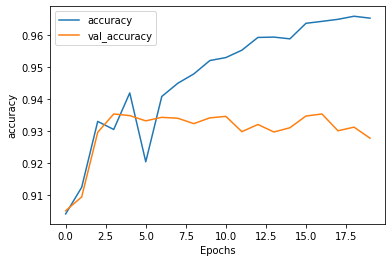

In [58]:
plot_graphs(history=history,metric='accuracy')

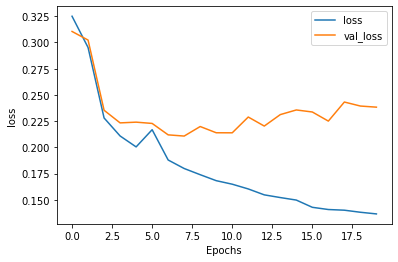

In [59]:
plot_graphs(history=history,metric='loss')